In [2]:
from csv_logger import *
from mish_activation import *

In [3]:
import os
import gc
import time
import numpy as np 
import pandas as pd

import torch
import torch.nn as nn
import torch.utils.data as D
from torch.optim.lr_scheduler import ExponentialLR
from torchvision import models, transforms as T
import torch.nn.functional as F

import cv2
import fastai
from fastai.vision import *
from fastai.callbacks.tracker import SaveModelCallback, ReduceLROnPlateauCallback

from albumentations import (
    Compose, OneOf,
    ShiftScaleRotate, IAAPerspective, IAAPiecewiseAffine
)
from albumentations.pytorch import ToTensor

import pretrainedmodels
# print(pretrainedmodels.model_names)

import warnings
warnings.filterwarnings('ignore')

## Config and helpers

In [4]:
config = {
    'PATH_DATA': '../',
    'PATH_WEIGHTS': '../NN_WEIGHTS/',
    'FOLD_NUMBER': 0,
    'FINETUNE': False,
    'SEED': 32,
    'CLASSES': 3,
    'CHANNELS': 1,
    'DEVICE': 'cuda',
    'N_FOLDS': 5,
    'IMG_SIZE': 128,
    'IMG_STATS': ([0.0692], [0.2051]),
    'NUM_WORKERS_ON_MACHINE': 16,
}
config['MODEL_NAME'] = 'SEResnext50-128x128-1ch-v5.1.4-{}fold'.format(config['FOLD_NUMBER'])

if config['FINETUNE']:
    IMAGES_FOLDER = 'train_orig_size'
    config['BATCH_SIZE'] = 196
else:
    IMAGES_FOLDER = 'train_resize'
    config['BATCH_SIZE'] = 256
    
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

In [5]:
def seed_torch(seed=42):
    import random; import os
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.empty_cache()
    
seed_torch(config['SEED'])

In [6]:
class MixLoss(Module):
    "Adapt the loss function `crit` to go with mixup &amp; cutmix."
    
    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'): 
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else: 
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if len(target.shape) == 2 and target.shape[1] == 7:
            loss1, loss2 = self.crit(output,target[:,0:3]), self.crit(output,target[:,3:6])
            #d = loss1 * target[:,-1] + loss2 * (1-target[:,-1])
            #d = loss2 * (1-target[:,-1])
            d = loss1 * target[:,-1]
        else:  
            d = self.crit(output, target)

        if self.reduction == 'mean':    
            return d.mean()
        elif self.reduction == 'sum':   
            return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'):  return self.old_crit
        elif hasattr(self, 'old_red'): 
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit
        
class CutMixUpCallback(LearnerCallback):
    "Callback that creates the mixed-up input and target."
    def __init__(self, learn:Learner, alpha:float=0.4, cutmix_prob:float=0.5, cutmix_alpha=1.0):
        super().__init__(learn)
        self.alpha = alpha
        self.cutmix_prob = cutmix_prob
        self.cutmix_alpha = cutmix_alpha

    def on_train_begin(self, **kwargs):
        self.learn.loss_func = MixLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if not train: 
            return

        # CutMix
        if np.random.random() > (1-self.cutmix_prob):
            B, CH, W, H = last_input.size(0), last_input.size(1), last_input.size(2), last_input.size(3)
            indices = torch.randperm(B).to(last_input.device)
            Lam = []
            new_input = last_input.clone()
            for i in range(B):
                lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
                lam = np.max([lam, 1 - lam])
                
                bbx1, bby1, bbx2, bby2 = rand_bbox(W, H, lam)
                new_input[i, :, bbx1:bbx2, bby1:bby2] = last_input[indices[i], :, bbx1:bbx2, bby1:bby2]
                # adjust lambda to exactly match pixel ratio
                Lam.append(1 - (bbx2 - bbx1) * (bby2 - bby1) / (W * H))
            Lam = last_input.new(Lam)
            new_target = torch.cat([last_target.float(), last_target[indices].float(), Lam[:,None].float()], 1)
            
        # MixUp
        else:
            lambd = np.random.beta(self.alpha, self.alpha, last_target.size(0))
            lambd = np.concatenate([lambd[:,None], 1-lambd[:,None]], 1).max(1)
            lambd = last_input.new(lambd)
            shuffle = torch.randperm(last_target.size(0)).to(last_input.device)
            # No stack x, compute x
            out_shape = [lambd.size(0)] + [1 for _ in range(len(last_input.shape) - 1)]
            new_input = (last_input * lambd.view(out_shape) + last_input[shuffle] * (1-lambd).view(out_shape))
            # Stack y
            new_target = torch.cat([last_target.float(), last_target[shuffle].float(), lambd[:,None].float()], 1)
            
        return {'last_input': new_input, 'last_target': new_target}  

    def on_train_end(self, **kwargs):
        self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(W, H, lam):
    
    cut_rat = np.sqrt(1. - lam) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

## Data

In [7]:
train_df = pd.read_csv(config['PATH_DATA']+'shorter_train_folds.csv')
train_df = train_df[train_df['fold'] != config['FOLD_NUMBER']]
train_df.drop('fold', axis=1, inplace=True)
train_df['is_valid'] = False

holdout = pd.read_csv(config['PATH_DATA']+'holdout.csv')
holdout['is_valid'] = True

In [8]:
train_df = train_df.append(holdout)
print('train_df.shape:', train_df.shape)

train_df.shape: (164689, 6)


In [9]:
nunique = list(train_df.nunique())[1:-2]
print('nunique:', nunique)

nunique: [168, 11, 7]


## Images

In [10]:
if not config['FINETUNE']:
    train_tf = Compose([
        OneOf([
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, always_apply=True),
            IAAPerspective(always_apply=True),
            IAAPiecewiseAffine(always_apply=True)
        ], p=0.5)
    ])

    def new_open_image(fn:PathOrStr, div:bool=True, convert_mode:str='L',
                       after_open:Callable=None, transforms=True)->Image:
        "Return `Image` object created from image in file `fn`."
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
            x = PIL.Image.open(fn).convert(convert_mode)
        if after_open: x = after_open(x)

        if transforms:
            transformed_im = train_tf(image=np.array(x))['image']
            x = pil2tensor(transformed_im, dtype=np.float32)
        else:
            x = pil2tensor(x, dtype=np.float32)
        if div: x.div_(255)
        return vision.Image(x)

    vision.data.open_image = new_open_image

In [11]:
im_list = ImageList.from_df(train_df, path=config['PATH_DATA'], folder=IMAGES_FOLDER, suffix='.png',
                            cols='image_id', convert_mode='L')

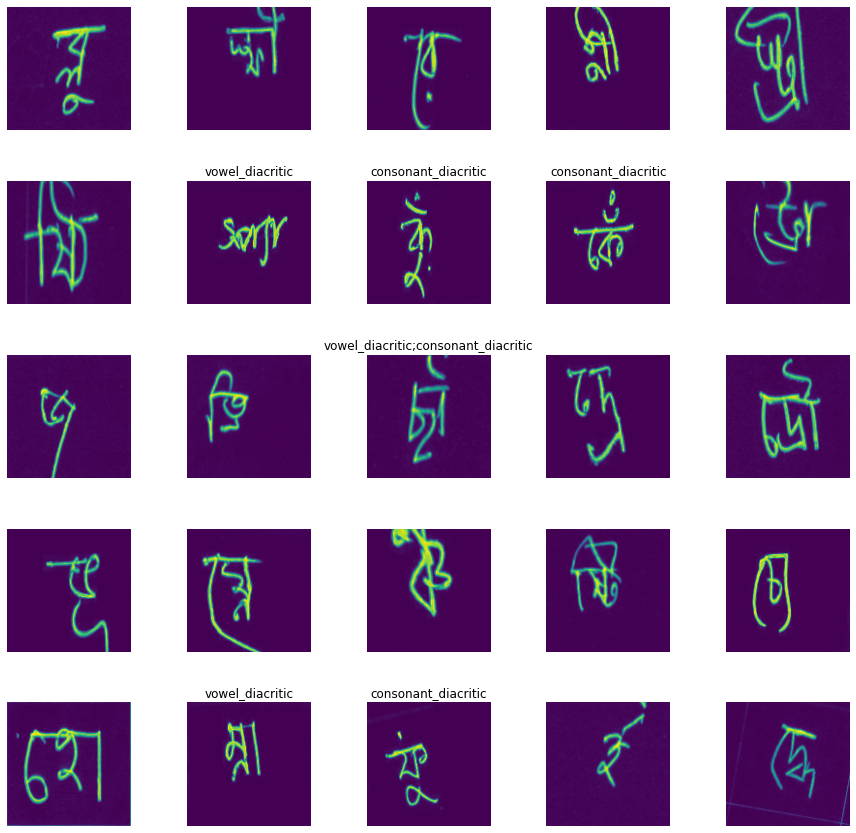

In [12]:
data = (im_list.split_from_df('is_valid')
               .label_from_df(cols=['grapheme_root','vowel_diacritic','consonant_diacritic'])
               .databunch(bs=config['BATCH_SIZE'], num_workers=config['NUM_WORKERS_ON_MACHINE'])
               .normalize(config['IMG_STATS']))

data.show_batch(5, figsize=(12,12))

## Model

In [13]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class PretrainedModel(nn.Module):
    def __init__(self, model_name='resnet18', num_classes=1000, num_channels=3,
                 pretrained=True, use_bn=False, verbose=False):
        super().__init__()
        self.model_name = model_name
        self.num_classes = num_classes
        self.num_channels = num_channels
        self.pretrained = pretrained
        self.use_bn = use_bn
        
        if self.use_bn: self.bn = nn.BatchNorm2d(self.num_channels)
        
        if self.pretrained:
            preloaded = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
        else:
            preloaded = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained=None)
        if verbose: print(preloaded)
        
        if self.num_channels < 3:
            trained_kernel = preloaded.layer0.conv1.weight
            new_conv = nn.Conv2d(self.num_channels, 64,
                                 kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
            with torch.no_grad():
                new_conv.weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*num_channels, dim=1)
            preloaded.layer0.conv1 = new_conv
        
        if self.model_name == 'se_resnext50_32x4d':
            preloaded.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        print('last_linear shape:', (preloaded.last_linear.in_features, preloaded.last_linear.out_features))
        fc_in_features = preloaded.last_linear.in_features
        preloaded.last_linear = Identity()
        self.features = preloaded
        
        self.fc_gr = self.get_head(fc_in_features, nunique[0], Mish())
        self.fc_vd = self.get_head(fc_in_features, nunique[1], Mish())
        self.fc_cd = self.get_head(fc_in_features, nunique[2], Mish())
        
    def get_head(self, in_features, out_features, act_func, bn=True, dropout_prob=0.0):
        layers = [act_func] + bn_drop_lin(in_features, out_features, bn, dropout_prob) #+ \
                    #bn_drop_lin(512, out_features, bn, dropout_prob)
        return nn.Sequential(*layers)
        
    def forward(self, x):
        if self.use_bn:
            x = self.bn(x)
        x = self.features(x)
        
        x1 = self.fc_gr(x)
        x2 = self.fc_vd(x)
        x3 = self.fc_cd(x)
        return x1, x2, x3

In [14]:
model = PretrainedModel(model_name='se_resnext50_32x4d',
                        num_classes=config['CLASSES'],
                        num_channels=config['CHANNELS'],
                        pretrained=True,
                        verbose=False).to(config['DEVICE'])

last_linear shape: (2048, 1000)


## Learn

In [15]:
def ohem_loss(cls_pred, cls_target, rate=0.7, reduction='none'):
    batch_size = config['BATCH_SIZE']
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction=reduction, ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate))
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss

In [16]:
class Loss_combine(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input, target, reduction='mean'):
        x1,x2,x3 = input
        x1,x2,x3 = x1.float(),x2.float(),x3.float()
        y = target.long()
        
        if config['FINETUNE']:
            return F.cross_entropy(x1,y[:,0],reduction=reduction) + \
                    F.cross_entropy(x2,y[:,1],reduction=reduction) + \
                    F.cross_entropy(x3,y[:,2],reduction=reduction)
        else:
            return ohem_loss(x1,y[:,0],rate=0.7) + \
                    ohem_loss(x2,y[:,1],rate=0.7) + \
                    ohem_loss(x3,y[:,2],rate=0.7)

In [17]:
class Metric_idx(Callback):
    def __init__(self, idx, average='macro'):
        super().__init__()
        self.idx = idx
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[:,self.idx]
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx,0)
Metric_vowel = partial(Metric_idx,1)
Metric_consonant = partial(Metric_idx,2)

class Metric_tot(Callback):
    def __init__(self):
        super().__init__()
        self.grapheme = Metric_idx(0)
        self.vowel = Metric_idx(1)
        self.consonant = Metric_idx(2)
        
    def on_epoch_begin(self, **kwargs):
        self.grapheme.on_epoch_begin(**kwargs)
        self.vowel.on_epoch_begin(**kwargs)
        self.consonant.on_epoch_begin(**kwargs)
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.grapheme.on_batch_end(last_output, last_target, **kwargs)
        self.vowel.on_batch_end(last_output, last_target, **kwargs)
        self.consonant.on_batch_end(last_output, last_target, **kwargs)
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 0.5*self.grapheme._recall() +
                0.25*self.vowel._recall() + 0.25*self.consonant._recall())

In [18]:
learn = Learner(data,
                model,
                loss_func=Loss_combine(),
                # opt_func=Over9000,
                metrics=[Metric_grapheme(),Metric_vowel(),Metric_consonant(),Metric_tot()],
                callback_fns=ShowGraph) #.to_fp16()

learn.path = Path(config['PATH_WEIGHTS']+config['MODEL_NAME'])

In [19]:
learn.model = nn.DataParallel(learn.model, device_ids=[0,1])

In [20]:
learn.split([model.fc_gr]);

---

In [21]:
def get_fn(a):
    while True:
        if hasattr(a, 'func'): a = a.func
        else: break
    return a

def show_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    rand_int = np.random.randint(len(xb))
    rand_img = Image(xb[rand_int])
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    cb_tfms = 0
    for cb in learn.callback_fns:
        if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
            cb_fn = partial(get_fn(cb), **cb.keywords)
            try:
                fig = plt.subplots(rows, cols, figsize=figsize)[1].flatten()
                plt.suptitle(get_fn(cb).__name__, size=14)
                [Image(cb_fn(learn).on_batch_begin(
                            xb, yb, True)['last_input'][0]).show(ax=ax)
                    for i, ax in enumerate(fig)]
                plt.show()
                cb_tfms += 1
                break
            except Exception as ex:
                plt.close('all')
    if cb_tfms == 0:
        if tfms is not None:
            t_ = []
            for t in learn.data.train_ds.tfms: t_.append(get_fn(t).__name__)
            title = f"{str(t_)[1:-1]} transforms applied"
        else: title = f'No transform applied'
        rand_int = np.random.randint(len(xb))
        fig = plt.subplots(rows, cols, figsize=figsize)[1].flatten()
        plt.suptitle(title, size=14)
        [rand_img.apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(fig)]
        plt.show()
    return learn

Learner.show_tfms = show_tfms
learn.callback_fns.append(partial(CutMixUpCallback, cutmix_prob=1.0, cutmix_alpha=0.6))

In [22]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 fastai.train.ShowGraph,
 functools.partial(<class '__main__.CutMixUpCallback'>, cutmix_prob=1.0, cutmix_alpha=0.6)]

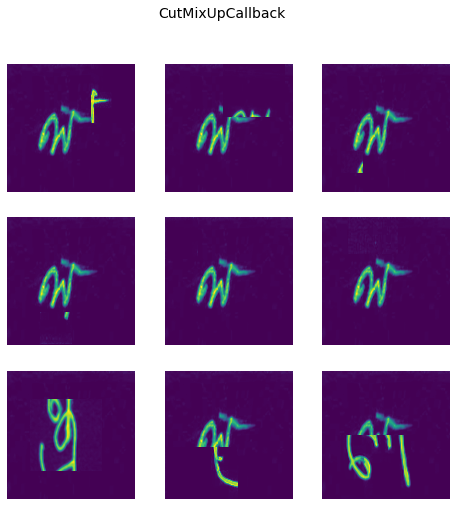

In [23]:
learn.show_tfms();

---

epoch,train_loss,valid_loss,metric_idx,metric_idx,metric_idx,metric_tot,time
0,2.621077,1.285557,0.781329,0.950514,0.924539,0.859428,04:01
1,2.104984,0.823209,0.893487,0.960990,0.942336,0.922575,03:57


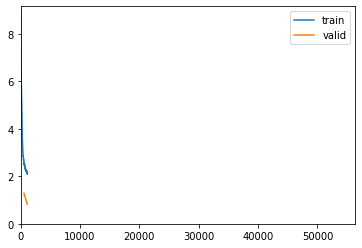

In [ ]:
if config['FINETUNE']:
    stage0_logger = pd.read_csv(learn.path/'logs_{}fold.csv'.format(config['FOLD_NUMBER']))
    best_epoch = stage0_logger['metric_tot'].idxmax()
    
    learn.load('{0}{1}/models/{1}_{3}_{2}'.format(config['PATH_WEIGHTS'], config['MODEL_NAME'], best_epoch, 'stage0'))
    learn.unfreeze()
    
    checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME']+'_stage1',
                                            every='epoch', monitor='valid_loss')
    # reduce lr by factor after patience epochs
    reduce_lr_callback = ReduceLROnPlateauCallback(learn, monitor='metric_tot',
                                                   factor=0.5, patience=5, min_lr=1e-6)
    logger = CSVLogger(learn, 'logs_{}fold'.format(config['FOLD_NUMBER']))

    learn.fit(
        40,
        lr=1e-2 / 10.,
        wd=0.,
        callbacks=[checkpoint_callback, reduce_lr_callback],
    )
else:
    learn.unfreeze()
    
    checkpoint_callback = SaveModelCallback(learn, name=config['MODEL_NAME']+'_stage0',
                                            every='epoch', monitor='valid_loss')
    # reduce lr by factor after patience epochs
    reduce_lr_callback = ReduceLROnPlateauCallback(learn, monitor='metric_tot',
                                                   factor=0.5, patience=5, min_lr=1e-6)
    logger = CSVLogger(learn, 'logs_{}fold'.format(config['FOLD_NUMBER']))

    learn.fit(
        100,
        lr=1e-2 / 10.,
        wd=0.,
        callbacks=[logger, checkpoint_callback, reduce_lr_callback],
    )

#metrics: Metric_grapheme, Metric_vowel, Metric_consonant, Metric_tot (competition metric)